# Yassine Abderrahmani

## Implémentation d'Algorithmes : Randomized SVD

* PROBABILISTIC ALGORITHMS FOR MATRIX APPROXIMATION

### Table of Contents

1. Dataset description : some results exemples
2. TIME and MEMORY Consumption
3. Decaying Singular Values
4. Errors Approximation
5. Image Reconstruction

* Prototype for Randomized SVD

Given an m × n matrix A, a target number k of singular vectors, and an exponent q (say, q = 1 or q = 2), this procedure computes an approximate rank-2k factorization $UΣV^*$, where U and V are orthonormal, and Σ is nonnegative and diagonal. 

<b>Stage A:</b>

1. Generate an n × 2k Gaussian test matrix <b>Ω</b>.
2. Form <b>$Y = (AA*)^qAΩ$</b> by multiplying alternately with A and A*.
3. Construct a matrix Q whose columns form an orthonormal basis for the range of Y .

<b>Stage B:</b>

4. Form <b>$B = Q^{*}A$</b>
5. Compute an SVD of the small matrix: <b>$B = ÜΣV^*$.</b>
6. Set <b>$U = QÜ$ .</b>

<B>Note:</b> The computation of <b>Y</b> in step 2 is vulnerable to round-off errors.
When high accuracy is required, we must incorporate an orthonormalization
step between each application of <b>A</b> and <b>A*</b>; see Algorithm 4.4.

MEMO

* TIME

In [ ]:
# start = time()

# end = time()
# print("Prediction made in {:.4f} secondes.".format(end - start))

* MEMORY : 2 ways

In [208]:
# First 
# Command line : whos

# Second : for numpy array -> Bytes to Mb

# print("%d Mb" % ((<np array name>.size * <np array name>.itemsize) * pow(2, -20)))

# Implementation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import scipy.sparse as sp
import scipy.io
from PIL import Image
from glob import glob
import cv2  # OpenCV autre façon...

from sklearn import preprocessing

from scipy.sparse import coo_matrix   # Sparse Matrices

from time import time

sns.set()

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

#### Randomized SVD

In [54]:
def matrix_generator(m, n):
    return np.random.randint(-20, 20, size=(m, n))

def gaussian_matrix_generator(n, k):
    # [[np.random.rand(), np.random.rand()] for aa in range(5)]
    # np.random.standard_normal(size=(3, 4))
    return np.random.randn(n, 2*k)

def svd(B):  # scipy is a little bit faster than numpy (but negligible ...)
#     u, s, vh = np.linalg.svd(B, full_matrices=False)   # False si on est sur que m < n => SVD bien pour les matrices avec Features en majorité (donc colones)
    u, s, vh = scipy.linalg.svd(B, full_matrices=False)
    return u,s,vh

def random_svd(A, k, q, plot_error=False):
    # STAGE A :
    
    print("A shape : ", A.shape)
    # generate n x 2k gaussian test matrix Gamma
    gamma = gaussian_matrix_generator(A.shape[1], k)
    
    # Algo 4.4 : because of round-off errors...
    Y0 = np.dot(A, gamma)
    if q > 0:
        for i in range(q):
            Y_temporary, _ = np.linalg.qr(np.dot(A.T, Y0))
            Q, _ = np.linalg.qr(np.dot(A, Y_temporary))
        print("\nY shape : ", Y_temporary.shape)
    else:
        # Construct a matrix Q whose columns form an orthonormal basis for the range of Y .
        print("\nY shape : ", Y0.shape)
        Q, _ = np.linalg.qr(Y0)    
        
    print("Q shape : ", Q.shape)
    
    # STAGE B :
    
    # Form B = Q*A.
    B = np.dot(Q.T, A)
    
    # Compute an SVD of the small matrix: B = ÜΣV*.
    U_prime, Epsilon, V_adj = svd(B)
    
    #Epsilon_mat = np.diag(Epsilon)
    #B_svd = np.dot(U_prime, np.dot(Epsilon_mat, V_adj))
    
    # Set U = Q.Ü.
    U = np.dot(Q, U_prime)
    
    # Truncate -> Get the Good rank k not 2*k...
    U, Epsilon, V_adj = U[:, :k], Epsilon[:k], V_adj[:k, :]
    
    # A_svd
    print("\nU shape : ", U.shape, "\nEpsilon shape : ", Epsilon.shape, "\nV_adj shape : ", V_adj.shape, "\n")
    # A_svd = np.dot(U, np.dot(Epsilon_mat, V_adj))
    
    # To plot the actual error we need Q : because el= ||A - QQ*A|| 
    if plot_error:
        return U, Epsilon, V_adj, Q
    
    return U, Epsilon, V_adj

# Practical Case : Image database for faces recognition 

Usage of Feret Database.  

**Memo :**  
* Unix Code for finding only images we want to play with :  
    * First create a new directory inside of `/colorferet`:  
    `mkdir final_image`  
    
    Then  :
    `cd colorferet/dvd1/data`

    **example** (before -> Show in terminal all names to be sure) :  
    `find -wholename '*images/*_f[ab]*' -exec echo '{}' \;`  
    This will show all files with [a] and [b] after "_f"  
    
    * Then for **all images** :  
    `find -wholename '*images/*_*' -exec cp {} ../../final_images/ \;`  
    
    * **Unzip** all files :  
    Into the Images Copy directory (**'/final_images'**) :  
    `bunzip2 *.bz2`
    



* Convert ppm file to jpg

In [ ]:
# PPM to JPG 
# Grayscale -> ( , , , 3) -> ( , , , 1)

name_ppm = os.listdir('./smaller_frontal_images/')

for i in name_ppm:
    img_temp = cv2.imread('./smaller_frontal_images/' + i, cv2.IMREAD_GRAYSCALE)
    cv2.imwrite('./smaller_front_jpg/'+ i.strip()[:-4] + '.jpg' , img_temp)

* Loading jpg images

In [4]:
# Load all jpg images to np.array
# using PIL.Image

filelist = glob('./smaller_front_jpg/*.jpg')
len(filelist)

x = np.array([np.array(Image.open(fname)) for fname in filelist])
x.shape    # -> (7810, 384, 256)   Grayscale here

(2722, 384, 256)

### Print samples of the dataset

In [5]:
def show_samples(x, rows, columns):
    fig = plt.figure(figsize=(20, 15))
#     columns = 5
#     rows = 5

    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns*rows):
        if (columns*rows < len(x)):
            # create subplot and append to ax
            ax.append(fig.add_subplot(rows, columns, i+1))
            ax[-1].set_title("image: "+str(i)) 
            plt.imshow(x[i], cmap = 'gray')                     # Utiliser cmap = 'gray' sinon donne du rouge...
            plt.axis('off')
        else:
            break

    plt.show() 

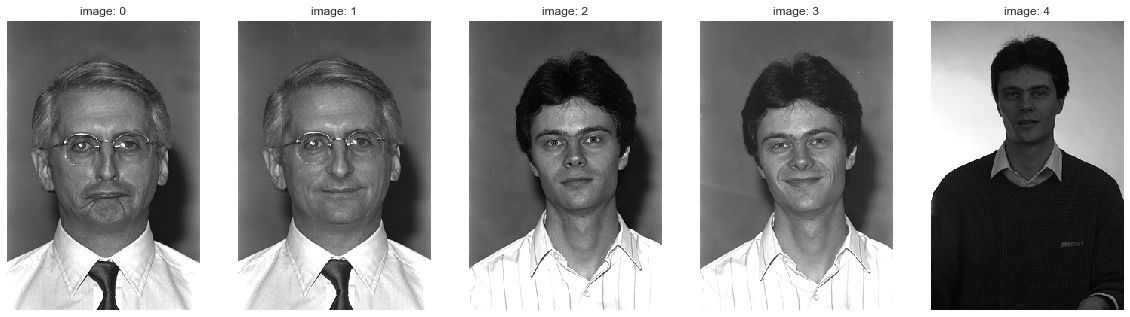

In [8]:
show_samples(x, 1, 5)

* Flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) : 
```python
X_flatten = X.reshape(X.shape[0], -1).T      
```

In [9]:
x_flatten = x.reshape(x.shape[0], -1).T

In [10]:
x_flatten.shape   # (98 304, 7810) if we take all images ... But here only 2722

(98304, 2722)

* **Centering** and **Scaling** to unit norm the matrix (very long !)

In [ ]:
# axis = 1 -> standardize each sample (the columns are the images here...)
# with_mean = True -> If True, center the data before scaling.
# with_std = True -> If True, scale the data to unit variance (or equivalently, unit standard deviation).

start = time()

x_scaled = preprocessing.scale(x_flatten, axis=1, with_mean=True, with_std=True)

end = time()
print("Preprocessing made in {:.4f} secondes.".format(end - start))

In [ ]:
x_scaled

* Save as npy file to reload much more faster...

In [ ]:
# np.savetxt('./x_scaled.csv', x_scaled, delimiter=',')

np.save('./x_scaled_frontal.npy', x_scaled)           # Quicker but binary file...

In [11]:
x_scaled = np.load('./x_scaled_frontal.npy')

In [12]:
x_scaled.shape

(98304, 2722)

In [145]:
start = time()

U, Eps, Vt = random_svd(x_scaled, k=100, q=3)


end = time()
print("Prediction made in {:.4f} secondes.".format(end - start))

A shape :  (98304, 2722)

Y shape :  (2722, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

Prediction made in 22.9065 secondes.


* Cheking the error value

In [15]:
_, _, _, Q_test = random_svd(x_scaled, k=50, q=3, plot_error=True)
error = np.linalg.norm(x_scaled - np.dot(Q_test, np.dot(Q_test.T, x_scaled)), 2)

error

A shape :  (98304, 2722)

Y shape :  (2722, 100)
Q shape :  (98304, 100)

U shape :  (98304, 50) 
Epsilon shape :  (50,) 
V_adj shape :  (50, 2722) 



535.1045635097704

* Complete SVD

In [21]:
start = time()

U_base_np, Eps_base_np, Vt_base_np = np.linalg.svd(x_scaled, full_matrices=False)

end = time()

print("U_base_np : ", U_base_np.shape)
print("Eps_base_np : ", Eps_base_np.shape)
print("Vt_base_np : ", Vt_base_np.shape)

print("Prediction made in {:.4f} secondes.".format(end - start))

U_base_np :  (98304, 2722)
Eps_base_np :  (2722,)
Vt_base_np :  (2722, 2722)
Prediction made in 102.6722 secondes.


#### Plotting U : left matrix of singular vectors 

It contains all faces features...

In [146]:
U_provi = U.reshape((384, 256, U.shape[1]))

In [147]:
U_provi.shape

(384, 256, 100)

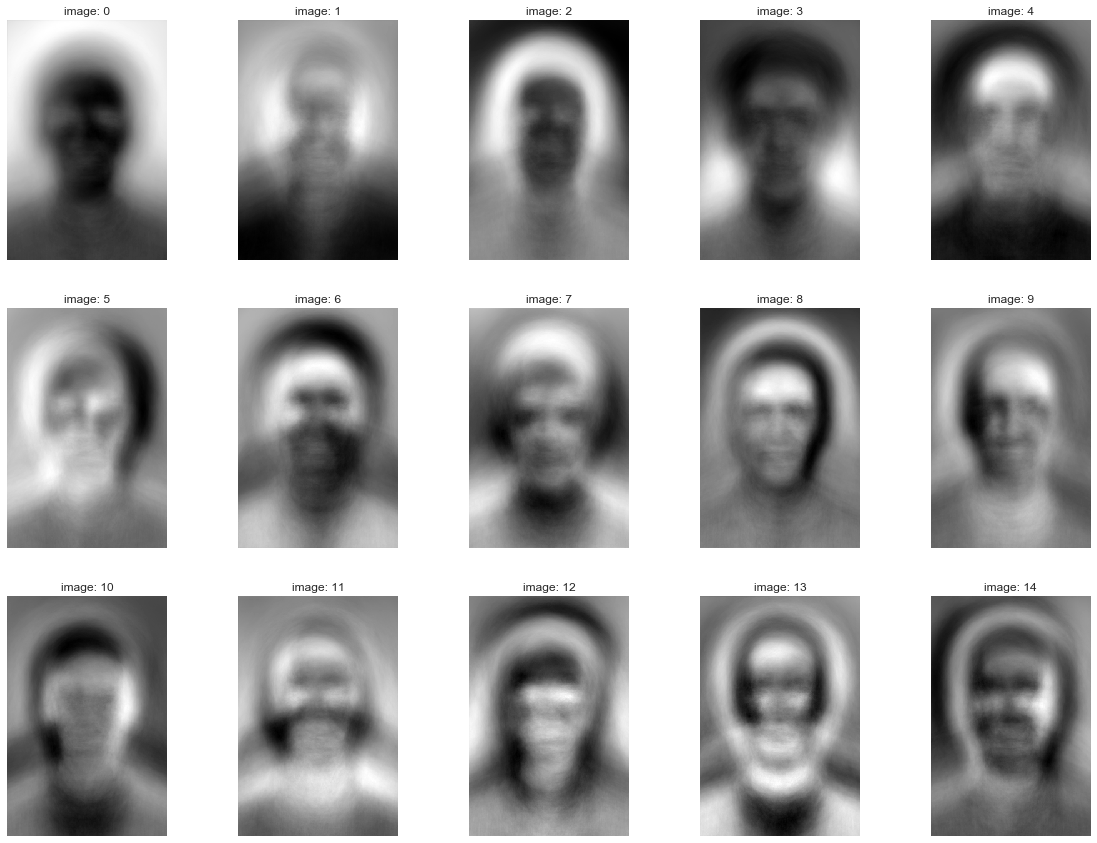

In [148]:
fig = plt.figure(figsize=(20, 15))
columns = 5
rows = 3

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    if (columns*rows <= U_provi.shape[2]):
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("image: "+str(i)) 
        plt.imshow(U_provi[:, :, i], cmap = 'gray')                     # Utiliser cmap = 'gray' sinon donne du rouge...
        plt.axis('off')
    else:
        break
        
plt.show() 

### Time & Memory Consumption

In [387]:
def time_memory(X):
    results = []
#     times = []
#     memory = []
    function_name = ["R-SVD", "SVD"]
    samples = [20, 60, 100, 200]
    q_power = [0, 1, 2, 3]
    
#     X = matrix_generator(1000,1000)
    
    for fct in function_name:
        if fct == "R-SVD":
            for s in samples:
                print("s : ", s)
                for q in q_power:
                    print("q : ", q)
                    # time
                    t0 = time()
                    uu, ss, vv = random_svd(X, k=s, q=q)
                    tf = time()
                    t = tf - t0

                    # memory
                    u_m = ((uu.size * uu.itemsize) * pow(2, -20))
                    s_m = ((ss.size * ss.itemsize) * pow(2, -20))
                    v_m = ((vv.size * vv.itemsize) * pow(2, -20))
                    memory = ((u_m + s_m + v_m))

                    results.extend([{
                            'time': "{:.2f}".format(t) + " s",
                            'samples': s,
                            'q_power': q,
                            'memory': "{:.2f}".format(memory) + " Mb",
                            'func_name': fct
                        }])
                    print("============")
        else:
            # time
            t0 = time()
            uu, ss, vv = np.linalg.svd(X, full_matrices=False)
            tf = time()
            t = tf - t0
            
            # memory
            u_m = ((uu.size * uu.itemsize) * pow(2, -20))
            s_m = ((ss.size * ss.itemsize) * pow(2, -20))
            v_m = ((vv.size * vv.itemsize) * pow(2, -20))
            memory = ((u_m + s_m + v_m))
            
            results.extend([{
                            'time': "{:.2f}".format(t) + " s",
                            'samples': str("full"),
                            'q_power': str("None"),
                            'memory': "{:.2f}".format(memory) + " Mb",
                            'func_name': fct
                        }])
            
    return pd.DataFrame(results)
        

In [388]:
results = time_memory(x_scaled)

s :  20
q :  0
A shape :  (98304, 2722)

Y shape :  (98304, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 

q :  1
A shape :  (98304, 2722)

Y shape :  (2722, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 

q :  2
A shape :  (98304, 2722)

Y shape :  (2722, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 

q :  3
A shape :  (98304, 2722)

Y shape :  (2722, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 

s :  60
q :  0
A shape :  (98304, 2722)

Y shape :  (98304, 120)
Q shape :  (98304, 120)

U shape :  (98304, 60) 
Epsilon shape :  (60,) 
V_adj shape :  (60, 2722) 

q :  1
A shape :  (98304, 2722)

Y shape :  (2722, 120)
Q shape :  (98304, 120)

U shape :  (98304, 60) 
Epsilon shape :  (60,) 
V_adj shape :  (60, 2722) 

q :  2
A shape :  (98304, 2722)

Y shape :  (272

In [390]:
results.groupby(['func_name', 'samples', 'q_power']).first()

time      memory
func_name samples q_power                      
R-SVD     20      0          5.66 s    15.42 Mb
                  1          2.44 s    15.42 Mb
                  2          3.12 s    15.42 Mb
                  3          4.37 s    15.42 Mb
          60      0          3.47 s    46.25 Mb
                  1          4.43 s    46.25 Mb
                  2          6.71 s    46.25 Mb
                  3          9.68 s    46.25 Mb
          100     0          5.62 s    77.08 Mb
                  1          9.05 s    77.08 Mb
                  2         15.49 s    77.08 Mb
                  3         17.98 s    77.08 Mb
          200     0         11.48 s   154.15 Mb
                  1         16.95 s   154.15 Mb
                  2         29.67 s   154.15 Mb
                  3         41.80 s   154.15 Mb
SVD       full    None     107.04 s  2098.05 Mb

##### Plotting Decaying Singular Values

It shows us the influence of the Power Iteration algorithm : The more q is high and the more decaying will be the singular values of our matrix.

A shape :  (98304, 2722)

Y shape :  (98304, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  1
A shape :  (98304, 2722)

Y shape :  (98304, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  1
q :  2
A shape :  (98304, 2722)

Y shape :  (98304, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  1
q :  2
q :  3
A shape :  (98304, 2722)

Y shape :  (98304, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 



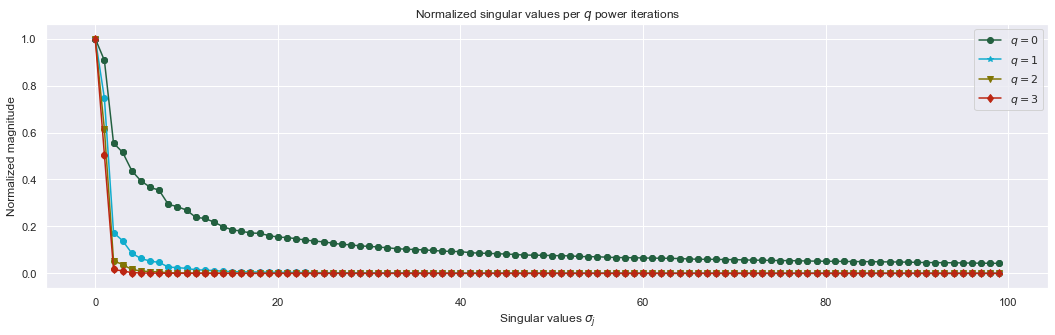

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 5)

qs = [(0, "#236040", 'o' ), (1, '#11accd', '*'), (2, '#807504', 'v'), (3, '#bc2612', 'd')]

for q, color, marker in qs:
    A_new = x_scaled
    for i in range(q):
        print("q : ", i+1)
        A_new = np.dot(x_scaled, np.dot(x_scaled.T, A_new))
    
    _, Eps_new, _ = random_svd(A_new, 100, 0)
    Eps_new = [e / Eps_new.max() for e in Eps_new]
    
    x_axis = range(len(Eps_new))
    ax.scatter(x_axis, Eps_new, color=color)
    ax.plot(x_axis, Eps_new, label=r'$q = %s$' % q, color=color, marker=marker)
    
    print("========")

ax.set_ylabel('Normalized magnitude')
ax.set_xlabel(r'Singular values $\sigma_j$')
ax.set_title('Normalized singular values per $q$ power iterations')
plt.legend()
plt.tight_layout()
plt.show()

q :  0
A shape :  (98304, 2722)

Y shape :  (98304, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  1
A shape :  (98304, 2722)

Y shape :  (2722, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  2
A shape :  (98304, 2722)

Y shape :  (2722, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 

q :  3
A shape :  (98304, 2722)

Y shape :  (2722, 200)
Q shape :  (98304, 200)

U shape :  (98304, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 2722) 



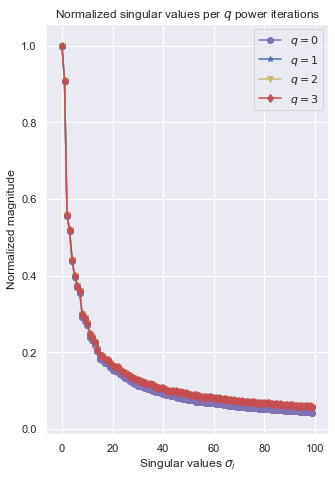

In [31]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 7)

qs = [ (0, 'm', 'o'), (1, 'b', '*'), (2, 'y', 'v'), (3, 'r', 'd')]
# qs = [(1, '#11accd', '*'), (2, '#807504', 'v')]

A_new = x_scaled

for q, color, marker in qs:
    print("q : ", q)
    _, Eps_new, _ = random_svd(A_new, 100, q)
    Eps_new = [e / Eps_new.max() for e in Eps_new]
    
    x_leng = range(len(Eps_new))
    ax.scatter(x_leng, Eps_new, color=color)
    ax.plot(x_leng, Eps_new, label=r'$q = %s$' % q, color=color, marker=marker)
    
    print("========")

ax.set_ylabel('Normalized magnitude')
ax.set_xlabel(r'Singular values $\sigma_i$')
ax.set_title('Normalized singular values per $q$ power iterations')
plt.legend()
plt.tight_layout()
plt.show()

### Plotting Errors Approximations

Plotting Approximate error against theorical error


Calcul Svd Minimal Error

Fin minimal error

l :  20

q :  0
A shape :  (98304, 2722)

Y shape :  (98304, 20)
Q shape :  (98304, 20)

U shape :  (98304, 10) 
Epsilon shape :  (10,) 
V_adj shape :  (10, 2722) 


q :  1
A shape :  (98304, 2722)

Y shape :  (2722, 20)
Q shape :  (98304, 20)

U shape :  (98304, 10) 
Epsilon shape :  (10,) 
V_adj shape :  (10, 2722) 


q :  2
A shape :  (98304, 2722)

Y shape :  (2722, 20)
Q shape :  (98304, 20)

U shape :  (98304, 10) 
Epsilon shape :  (10,) 
V_adj shape :  (10, 2722) 


q :  3
A shape :  (98304, 2722)

Y shape :  (2722, 20)
Q shape :  (98304, 20)

U shape :  (98304, 10) 
Epsilon shape :  (10,) 
V_adj shape :  (10, 2722) 


l :  40

q :  0
A shape :  (98304, 2722)

Y shape :  (98304, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 


q :  1
A shape :  (98304, 2722)

Y shape :  (2722, 40)
Q shape :  (98304, 40)

U shape :  (98304, 20) 
Epsilon shape :  (20,) 
V_adj shape :  (20, 2722) 


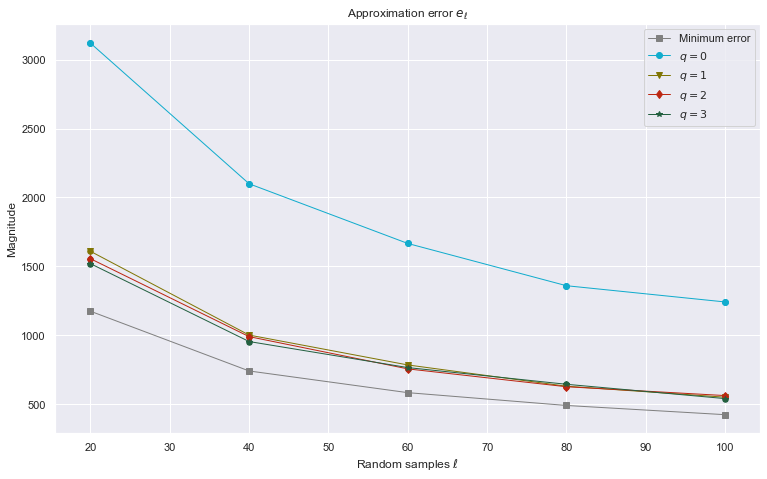

In [20]:
mins = []
q_dict = {
    0: ([], 'm', 'o'),
    1: ([], 'b', 'v'),
    2: ([], 'y', 'd'),
    3: ([], 'r', '*')
}

l_axis = [20, 40, 60, 80, 100]
q_power_iteration = [0, 1, 2, 3]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(11, 7)

start = time()

print("\nCalcul Svd Minimal Error")

S = scipy.linalg.svd(x_scaled, compute_uv=False)

print("\nFin minimal error")
print("===================")

for l in l_axis:
    
    # Theoretical minimum error for each l.
    print("\nl : ", l)
    min_l = S[l + 1]
    mins.append(min_l)

    # Compute error for each number of subspace iterations.
    for q in q_power_iteration:
        print("\nq : ", q)
        _, _, _, Q = random_svd(x_scaled, k=int(l/2), q=q, plot_error=True)
        error = np.linalg.norm(x_scaled - np.dot(Q, np.dot(Q.T, x_scaled)), 2)
        q_dict[q][0].append(error)

end = time()
print("\nPrediction made in {:.4f} secondes.".format(end - start))

ax.scatter(l_axis, mins, color='gray', s=30)
ax.plot(l_axis, mins, color='gray', label='Minimum error', marker='s', linewidth=1)

for q in q_power_iteration:
    data, color, marker = q_dict[q]
    ax.scatter(l_axis, data, s=30,
               color=color)
    ax.plot(l_axis, data, linewidth=1, color=color, label=r'$q = %s$' % q, marker=marker)

ax.set_ylabel('Magnitude')
ax.set_xlabel(r'Random samples $\ell$')
ax.set_title(r'Approximation error $e_{\ell}$')
plt.legend()
plt.tight_layout()
plt.savefig('./Errors.png')
plt.show()

#### Image Reconstruction

U size :  (384, 384) S size :  (256, 256) V size :  (256, 256)
U size :  (384, 256) S size :  (256, 256) V size :  (256, 256)
A shape :  (384, 256)

Y shape :  (384, 30)
Q shape :  (384, 30)

U shape :  (384, 15) 
Epsilon shape :  (15,) 
V_adj shape :  (15, 256) 

A shape :  (384, 256)

Y shape :  (384, 100)
Q shape :  (384, 100)

U shape :  (384, 50) 
Epsilon shape :  (50,) 
V_adj shape :  (50, 256) 

A shape :  (384, 256)

Y shape :  (384, 200)
Q shape :  (384, 200)

U shape :  (384, 100) 
Epsilon shape :  (100,) 
V_adj shape :  (100, 256) 



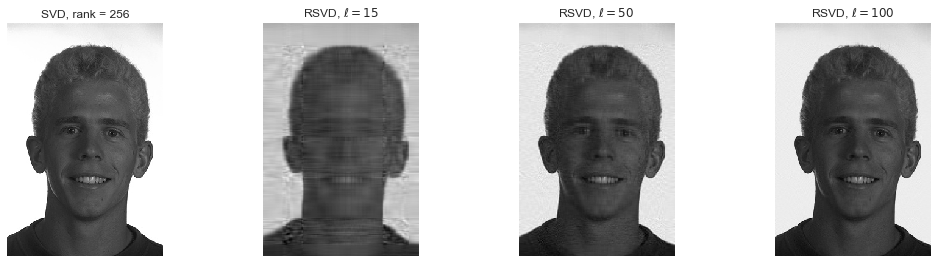

In [198]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(15, 4)

# Load our image
filelist = glob('./image_for_reconstruction/reconstruction_face.jpg')
# len(filelist)

x_reconstruction = np.array(Image.open(filelist[0]))
rank = min(x_reconstruction.shape)

U_test, S_test, Vt_test = np.linalg.svd(x_reconstruction)
S_diag_test = np.diag(S_test)

print("U size : ", U_test.shape, "S size : ", S_diag_test.shape, "V size : ", Vt_test.shape)

U_test, S_diag_test, Vt_test = U_test[:, :rank], S_diag_test[:rank, :rank], Vt_test[:rank, :]

print("U size : ", U_test.shape, "S size : ", S_diag_test.shape, "V size : ", Vt_test.shape)


img_recon = np.dot(U_test, np.dot(S_diag_test, Vt_test))
axarr[0].imshow(img_recon, cmap='gray')
axarr[0].axis('off')
axarr[0].set_title(r'SVD, rank = %s' % rank)

for i, l in enumerate([15, 50, 100]):
    U_test, S_test, Vt_test = random_svd(x_reconstruction, k=l, q=0)
    S_diag_test = np.diag(S_test)
    img_recon = np.dot(U_test, np.dot(S_diag_test, Vt_test))
    imwrite(fname, img_recon.astype(np.uint8))
    axarr[i+1].imshow(img_recon, cmap='gray')
    axarr[i+1].axis('off')
    axarr[i+1].set_title(r'RSVD, $\ell = %s$' % l)

plt.tight_layout()
plt.show()